**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**October, 2023**

---

# Analysis of cytokines and their receptors in peripheral blood (PBMCs)
This notebook uses the 10x single-cell dataset: 10k Human PBMCs, 3' v3.1, Chromium Controller

Single Cell Gene Expression Dataset by Cell Ranger 6.1.0


https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_Controller/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.h5

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import anndata
import matplotlib.pyplot as plt

In [63]:
def identityTransfer(adata_CellsNewID, adata, field='cell_type'):
    
    '''
    Function to transfer the value in a .obs column, modifying only the cells included in adata_CellsNewID
    
    Parameters:
        adata_CellsNewID: anndata object with cells. These should have in their .obs[field] the new values to be transfer to adata
        adata: anndata object to modify. The value in .obs[field] will be modifies for all the cells in adata_CellsNewID
        field: column name in .obs to operate in.
        
     Return:
        anndata object with the metadata modified
        
    '''
    
    #converting categorical into strings to introduce new categories
    adata.obs[field]=adata.obs[field].astype("string")


    #assigning the new categories to the cells in adata
    for cell in adata_CellsNewID.obs.index:
        adata.obs[field][cell] = adata_CellsNewID.obs[field][cell]

    #Returning strings into categorical 
    adata.obs[field]=adata.obs[field].astype("category")
    
    return(adata)

In [108]:
sc.settings.figdir = '../results/'

In [30]:
adata = sc.read_10x_h5('../data/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.h5')    

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [31]:
adata

AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [32]:
adata.var_names_make_unique()

In [33]:
adata.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38
AC023491.2,ENSG00000278633,Gene Expression,GRCh38
AC007325.1,ENSG00000276017,Gene Expression,GRCh38
AC007325.4,ENSG00000278817,Gene Expression,GRCh38


## Basic filtering
This dataset is already QC'd

In [34]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [35]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [36]:
adata.shape

(11428, 21874)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


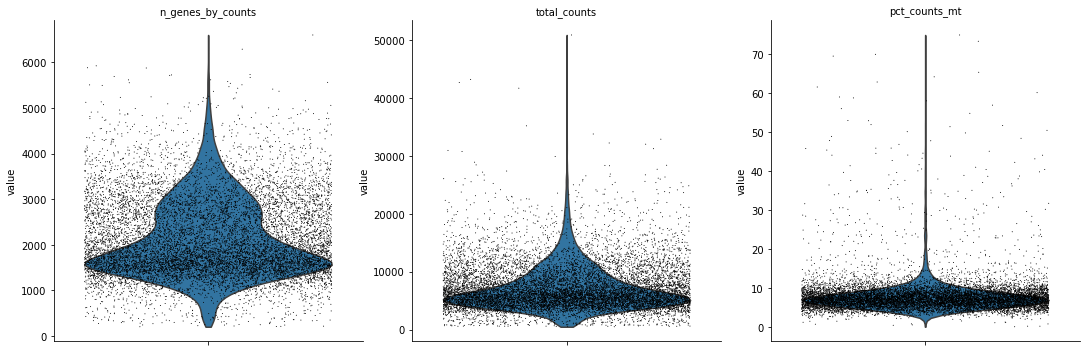

In [37]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

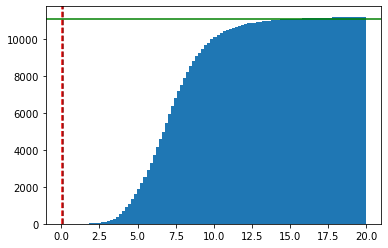

In [42]:
#Histogram Y number of cells, X mitocondrial percentage
plt.hist(adata.obs['pct_counts_mt'], bins = 100, cumulative=True)
plt.axvline(0.05, linestyle = '--', color = 'red')
plt.axvline(0.1, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [43]:
adata = adata[adata.obs.pct_counts_mt < 10, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


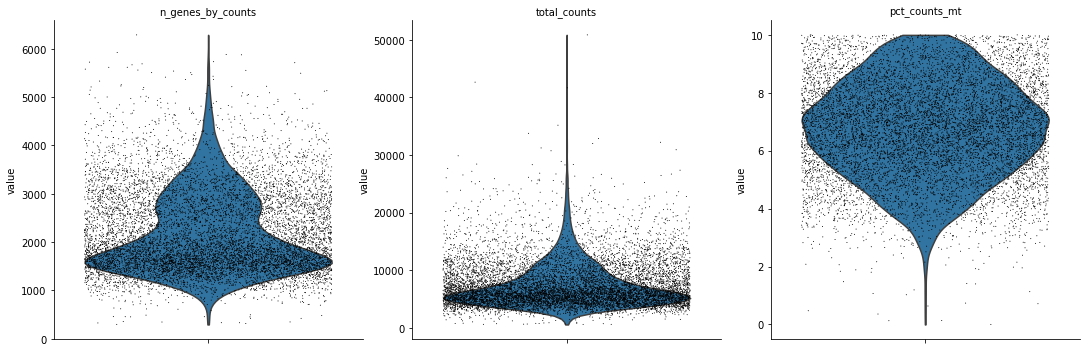

In [44]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

## Normalization

In [45]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


# Clustering

In [49]:
sc.tl.pca(adata, svd_solver='arpack')

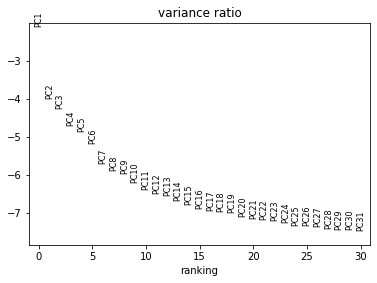

In [50]:
sc.pl.pca_variance_ratio(adata, log=True)

In [54]:
sc.set_figure_params(figsize=(5,5))

In [52]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)
sc.tl.umap(adata)

#clustering
sc.tl.leiden(adata, resolution=0.3)

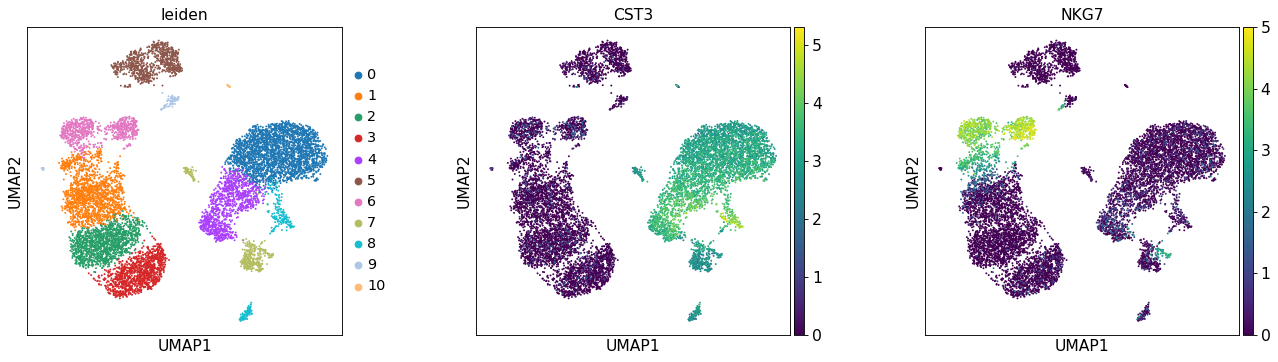

In [62]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'], wspace=0.3 )

## Annotation

In [70]:
marker_genes = ['CD3G', #T cells
                'IL7R', 'CD4', # CD4 T cells
                 'CD8A', 'CD8B', #CD8 t cells
                
                'CD19', 'MS4A1', #B cells
                
                'S100A8',#monocytes
                'LYZ', 'CD14', # CD14 monocytes
                'FCGR3A', 'MS4A7', # CD16+ monocytes
                
                 
                'GNLY', 'NKG7', 'KLRB1', #NK Cells
                
                
                'FCER1A', 'CST3', #DCs
                
                'PPBP', #megakaryocytes,
                "HBA1",
                'leiden']

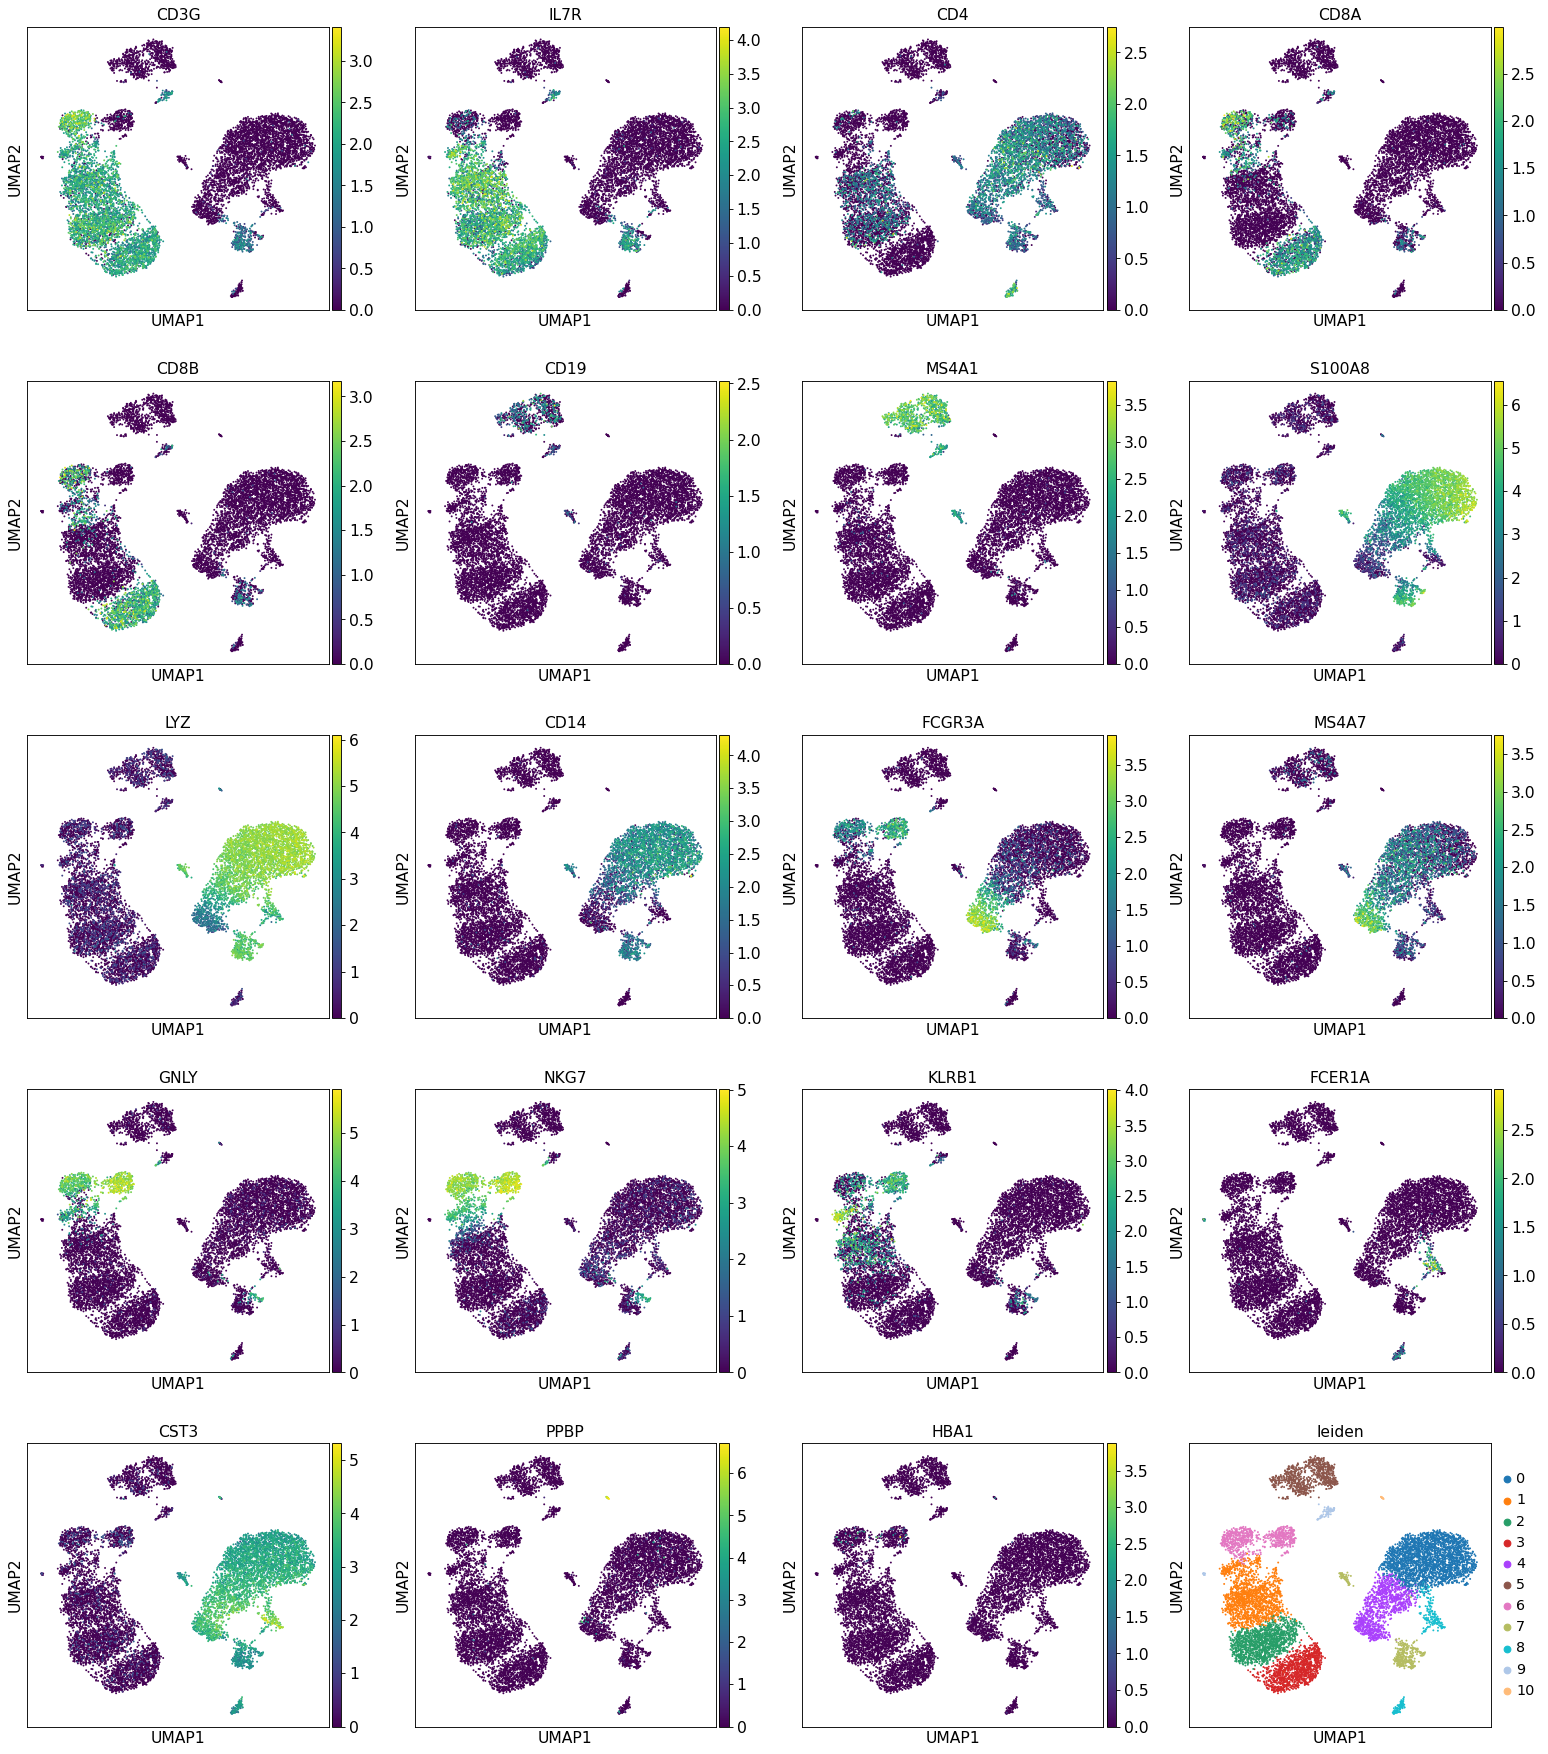

In [71]:
sc.pl.umap(adata, color=marker_genes)

In [73]:
#COpying the value of the leiden cluster. The new column will help to change it's values for
# the cluster identity
adata.obs['cell_type']= adata.obs['leiden']


#Function that changes the cluster names as indicated
adata.obs['cell_type'] = (adata.obs["leiden"].map(lambda x: 
                            {"0": "CD14 Monocytes", "1": "CD4 T_cells", "2": "CD4 T_cells", "3": "CD8 T_cells",
                             "4": "CD16 Monocytes","5": "B cells",
                            "6": "NK cells", "7": "lowQC", "8": "DCs", "9": "lowQC", "10": "Megakaryocytes"}
                            .get(x, x)).astype("category"))

In [75]:
# Removing lowQC clusters
adata = adata[adata.obs['cell_type'] != 'lowQC']


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


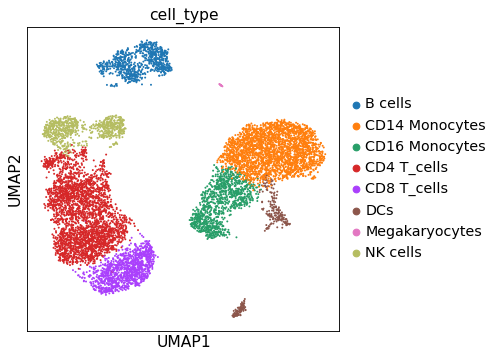

In [76]:
sc.pl.umap(adata, color='cell_type')

## Expression of receptors of cytokine upregulated by HBCs after placental infection

In [82]:
receptors=["CXCR1","CXCR2","CCR1","CCR3","CCR5","CCR6"]

In [80]:
adata

View of AnnData object with n_obs × n_vars = 9545 × 21874
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

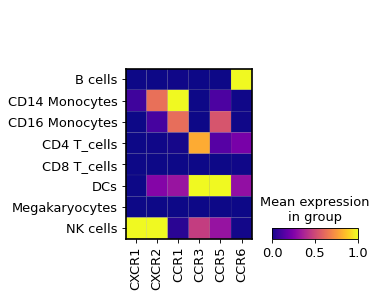

In [110]:
#order=["HBC-Lm_24h", 'PAMM1-Lm_24h']

gs = sc.pl.matrixplot(adata, receptors, groupby='cell_type',cmap='plasma',
                      save="cytokineReceptorInflamm_PBMC.pdf", standard_scale='var')

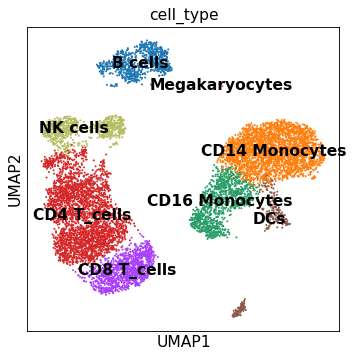

In [115]:
sc.pl.umap(adata, color='cell_type', save="PBMCs.pdf", legend_loc='on data',legend_fontsize='medium' )